In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install networkx[default]

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.2 MB 53.4 MB/s 
     |████████████████████████████████| 900 kB 56.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 7.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 6.8 MB/s 
     |████████████████████████████████| 6.5 MB 28.0 MB/s 
     |████████████████████████████████| 895 kB 45.9 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install stanza

     |████████████████████████████████| 432 kB 9.0 MB/s 
     |████████████████████████████████| 175 kB 56.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=a696a07f40a5a7586661473bc3fa90aced1d5a7dccd9f59eec29b010c8381722
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt  # drawing heat map of attention weights

plt.rcParams['font.sans-serif'] = ['SimSun']  # set font family

In [ ]:
from transformers import BertTokenizer, BertModel, pipeline
import torch
import numpy as np
import pandas as pd
import networkx as nx
import stanza

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [ ]:
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
perturb_file = open("/content/drive/My Drive/U2/COMP599/perturbed_sentences.txt")
file_contents = perturb_file.read()
perturb_sents = file_contents.splitlines()
perturb_sents = [{'original' : perturb_sents[i], 'good' : perturb_sents[i+1], 'bad' : perturb_sents[i+2]} for i in range(0, len(perturb_sents), 3)]
perturb_sents #dictionary of three sentences labeled original, good, bad

[{'bad': 'the car eats food',
  'good': 'the boy eats food',
  'original': 'the dog eats food'},
 {'bad': 'previously only fruits had seen the jets',
  'good': 'previously only scientists had seen the jets',
  'original': 'previously only people had seen the jets'},
 {'bad': 'my ideas sleep well at night',
  'good': 'my children sleep well at night',
  'original': 'my pets sleep well at night'},
 {'bad': 'the plant runs around the track',
  'good': 'the athlete runs around the track',
  'original': 'the horse runs around the track'},
 {'bad': 'a keen guitarist, he played a hat there the same year',
  'good': 'a keen guitarist, he played a guitar there the same year',
  'original': 'a keen guitarist, he played a concert there the same year'},
 {'bad': 'the cricket team won the apple last week',
  'good': 'the cricket team won the tournament last week ',
  'original': 'the cricket team won the game last week'},
 {'bad': 'they are usually artists who want to walk a bunch of stuff',
  'goo

In [ ]:
# some functions to analyze the probability of perturbed sentences
def get_top_n(m, k, sents):
  unmasker = pipeline('fill-mask', model=m, tokenizer="bert-base-uncased")
  adjs = []
  for s in sents:
    tokes = []
    a = unmasker(s, top_k=k)
    for i in a:
      tokes.append([i['score'], i['token_str']])
      adjs.append(i['token_str'])
    #for t in tokes:
      #print(t)
    #print()
  return tokes

def sent_probs(w1, w2, w3, sent, unmasker):
  return unmasker([sent], targets=[w1, w2, w3])

In [ ]:
def get_attention(sent, model, tokenizer):
  with torch.no_grad():
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    attention = model(input_ids, token_type_ids=token_type_ids)
  return attention[2]

def plot_attention(data, X_label=None, Y_label=None):
    '''
      Plot the attention model heatmap
      Args:
        data: attn_matrix with shape [ty, tx], cutted before 'PAD'
        X_label: list of size tx, encoder tags
        Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8))  # set figure size
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)

    # Set axis labels
    if X_label != None and Y_label != None:
        #X_label = [x_label for x_label in X_label]
        #Y_label = [y_label for y_label in Y_label]

        xticks = range(0, len(X_label))
        ax.set_xticks(xticks, minor=False)  # major ticks
        ax.set_xticklabels(X_label, minor=False, rotation=45)  # labels should be 'unicode'

        yticks = range(0, len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor=False)  # labels should be 'unicode'

        ax.grid(True)

    # Save Figure
    plt.title(u'Attention Heatmap')
    fig.show
    return fig

#convert the attention scores into a ranking

def convert_to_ranking(att):
  return torch.sort(att, descending=True)[1]

#lets compare 2 sents

def compare_att_dist(a1, a2): #takes the attention distribution to be the same if the attention distributions are at least 3 similar, this is a choice that can be experimented with
  #val = bool(a1[0] == a2[0] and a2[1] == a2[1] and a1[2] == a2[2])
  val = torch.equal(a1, a2)
  return val

def compare_three_att_dist(a1, a2, a3): #takes the attention distribution to be the same if the attention distributions are at least 3 similar, this is a choice that can be experimented with
  #val = bool(a1[0] == a2[0] and a2[1] == a2[1] and a1[2] == a2[2])
  val = bool(torch.equal(a1[:len(a1) // 2], a2[:len(a1) // 2])) and bool(torch.equal(a1[:len(a1) // 2], a3[:len(a1) // 2]))
  return val

def compare_atts(att1, att2, s1, s2):
  sim_dict = {}
  t = 0
  similar_heads = []
  for layer in range(12):
    for head in range(12):
      sim_dict[(layer, head)] = []
      head_att1 = att1[layer][0][head]
      head_att2 = att2[layer][0][head]
      head_rank1 = convert_to_ranking(head_att1)
      head_rank2 = convert_to_ranking(head_att2)
      for i in range(len(head_rank1)):
        #sim_dict[str(layer+1) + "-" + str(head+1)].append(torch.equal(head_rank1[i], head_rank2[i]))
        sim_dict[(layer, head)].append(compare_att_dist(head_rank1[i], head_rank2[i]))
        t += compare_att_dist(head_rank1[i], head_rank2[i])
        if compare_att_dist(head_rank1[i], head_rank2[i]) and (layer, head) not in similar_heads:
          similar_heads.append((layer, head))
  #print(t)
  return s1, s2, t, similar_heads, sim_dict

def compare_three_atts(att1, att2, att3, s1, s2, s3):
  sim_dict = {}
  t = 0
  similar_heads = []
  for layer in range(12):
    for head in range(12):
      sim_dict[(layer, head)] = []
      head_att1 = att1[layer][0][head]
      head_att2 = att2[layer][0][head]
      head_att3 = att3[layer][0][head]
      head_rank1 = convert_to_ranking(head_att1)
      head_rank2 = convert_to_ranking(head_att2)
      head_rank3 = convert_to_ranking(head_att3)
      for i in range(len(head_rank1)):
        #sim_dict[str(layer+1) + "-" + str(head+1)].append(torch.equal(head_rank1[i], head_rank2[i]))
        sim_dict[(layer, head)].append(compare_three_att_dist(head_rank1[i], head_rank2[i], head_rank3[i]))
        t += compare_three_att_dist(head_rank1[i], head_rank2[i], head_rank3[i])
        if compare_three_att_dist(head_rank1[i], head_rank2[i], head_rank3[i]) and (layer, head) not in similar_heads:
          similar_heads.append((layer, head))
  #print(t)
  return s1, s2, s3, t, similar_heads, sim_dict

def get_best_heads(sim): #gets the heads, whose attention dist for every word are the same
  best_heads = []
  for k in sim.keys():
    if sum(sim[k]) == 5:
      best_heads.append(k)
  return best_heads

def triplet_compare(sent_list, model, tokenizer):
  a1 = get_attention(sent_list['original'], model, tokenizer)
  a2 = get_attention(sent_list['good'], model, tokenizer)
  a3 = get_attention(sent_list['bad'], model, tokenizer)
  #print(compare_atts(a1, a2, sent_list['original'], sent_list['good']))
  sim_list = [compare_three_atts(a1, a2, a3, sent_list['original'], sent_list['good'], sent_list['bad'])]
  return sim_list

def compare_data_set(sent_list, model, tokenizer):
  results = pd.DataFrame(columns=["triplet", "sent_1", "sent_2", "sent_3", "score", "similar_heads", "sim_dict"])
  for i, d in enumerate(sent_list):
    result = triplet_compare(d, model, tokenizer)
    #print(result)
    result = [[i] + list(r) for r in result]
    result = pd.DataFrame(result, columns=["triplet", "sent_1", "sent_2", "sent_3", "score", "similar_heads", "sim_dict"])
    results = pd.concat([results, result])
  return results

In [ ]:
sentence_data = pd.read_csv('/content/drive/MyDrive/U2/COMP599/perturbed_sentence_data.csv')
scores_g = sentence_data[sentence_data['G-or-U'] == 'G']['Score']
scores_u = sentence_data[sentence_data['G-or-U'] == 'U']['Score']
print(scores_g.mean())
print(scores_g.std())
print(scores_u.mean())
print(scores_u.std())

0.1701798746
0.24899871519561467
0.000264094015
0.0003878947174250471


In [ ]:
r = compare_data_set(perturb_sents, model, tokenizer)
r = r.reset_index(drop=True)
sim_heads_list = list(r['similar_heads'])

In [ ]:
r_three = compare_data_set(perturb_sents, model, tokenizer)
r_three = r_three.reset_index(drop=True)
sim_heads_list = list(r_three['similar_heads'])

In [ ]:
r_three

,triplet,sent_1,sent_2,sent_3,score,similar_heads,sim_dict
0,0,the dog eats food,the boy eats food,the car eats food,295,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [True, True, False, False, True, True..."
1,1,previously only people had seen the jets,previously only scientists had seen the jets,previously only fruits had seen the jets,188,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 6...","{(0, 0): [True, False, True, False, False, Fal..."
2,2,my pets sleep well at night,my children sleep well at night,my ideas sleep well at night,229,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [False, True, False, False, False, Fa..."
3,3,the horse runs around the track,the athlete runs around the track,the plant runs around the track,146,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [True, False, False, False, False, Fa..."
4,4,"a keen guitarist, he played a concert there th...","a keen guitarist, he played a guitar there the...","a keen guitarist, he played a hat there the sa...",154,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [False, False, False, False, False, F..."
5,5,the cricket team won the game last week,the cricket team won the tournament last week,the cricket team won the apple last week,134,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [False, False, True, False, False, Fa..."
6,6,they are usually artists who want to do a bunc...,they are usually artists who want to paint a b...,they are usually artists who want to walk a bu...,190,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [False, False, True, False, True, Tru..."
7,7,people in europe captured birds for festivals,people in europe hunted birds for festivals,people in europe drank birds for festivals,198,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [True, False, False, False, False, Tr..."
8,8,the girl eats bread,the girl eats apples,the girl eats sunshine,356,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [True, False, False, False, False, Tr..."
9,9,the girl reads her book in the library,the girl reads her book in the car,the girl reads her book in the table,176,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...","{(0, 0): [True, True, False, False, True, Fals..."


In [ ]:
len(sim_heads_list[5])

67

In [ ]:
r1 = list(r[(r.index % 3) == 0]['score'])
print(r[(r.index % 3) == 0]['score'].mean())
print(r[(r.index % 3) == 0]['score'].std())
print(r[(r.index % 3) != 0]['score'].mean())
print(r[(r.index % 3) != 0]['score'].std())

163.8
75.81528800141065
133.725
60.528436843079525


In [ ]:
stanza.download('en')
nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse', use_gpu=False, pos_batch_size=3000) # Build the pipeline, specify part-of-speech processor's batch size

2022-04-11 18:50:52 INFO: Downloading default packages for language: en (English)...


2022-04-11 18:51:17 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-04-11 18:51:17 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-04-11 18:51:17 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-04-11 18:51:17 INFO: Use device: cpu
2022-04-11 18:51:17 INFO: Loading: tokenize
2022-04-11 18:51:17 INFO: Loading: pos
2022-04-11 18:51:17 INFO: Loading: lemma
2022-04-11 18:51:17 INFO: Loading: depparse
2022-04-11 18:51:18 INFO: Done loading processors!


In [ ]:
perturb_file = open("/content/drive/My Drive/U2/COMP599/perturbed_sentences.txt")
file_contents = perturb_file.read()
perturb_sents_list = file_contents.splitlines()
all_sents = "\n\n".join(perturb_sents_list)
doc_all = nlp(all_sents) # Run the pipeline on the input text

In [ ]:
#gets the dependency parses of the target sentences

dependency_dict = {}
for i,sent in enumerate(doc_all.sentences):
  #print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for word in sent.words], sep='\n')
  deplist = [(word.id, word.head, word.deprel) for word in sent.words]
  deplist = [dep for dep in deplist if dep[2] != 'root']
  #print(deplist)
  #print('\n')
  dependency_dict[i] = deplist

target_sents_deps_labeled = {d : dependency_dict[d] for d in dependency_dict.keys() if d % 3 == 0}
target_sents_deps_unlabeled = {d : [target_sents_deps_labeled[d][i][:-1] for i in range(len(target_sents_deps_labeled[d]))] for d in target_sents_deps_labeled.keys()}
target_sents_deps_unlabeled

{0: [(1, 2), (2, 3), (4, 3)],
 3: [(1, 5), (2, 3), (3, 5), (4, 5), (6, 7), (7, 5)],
 6: [(1, 2), (2, 3), (4, 3), (5, 6), (6, 3)],
 9: [(1, 2), (2, 3), (4, 6), (5, 6), (6, 3)],
 12: [(1, 3),
  (2, 3),
  (3, 6),
  (4, 6),
  (5, 6),
  (7, 8),
  (8, 6),
  (9, 6),
  (10, 12),
  (11, 12),
  (12, 6)],
 15: [(1, 3), (2, 3), (3, 4), (5, 6), (6, 4), (7, 8), (8, 4)],
 18: [(1, 4),
  (2, 4),
  (3, 4),
  (5, 6),
  (6, 4),
  (7, 8),
  (8, 6),
  (9, 10),
  (10, 8),
  (11, 12),
  (12, 10)],
 21: [(1, 4), (2, 3), (3, 1), (5, 4), (6, 7), (7, 4)],
 24: [(1, 2), (2, 3), (4, 3)],
 27: [(1, 2), (2, 3), (4, 5), (5, 3), (6, 8), (7, 8), (8, 3)],
 30: [(1, 2), (2, 3), (4, 5), (5, 3), (6, 8), (7, 8), (8, 5)],
 33: [(1, 3), (2, 3), (4, 6), (5, 6), (6, 3)],
 36: [(1, 2), (3, 5), (4, 5), (5, 2)],
 39: [(1, 2), (2, 3), (4, 6), (5, 6), (6, 3), (7, 9), (8, 9), (9, 3)],
 42: [(1, 2), (3, 4), (4, 2), (5, 7), (6, 7), (7, 2)],
 45: [(1, 2), (3, 4), (4, 2), (5, 7), (6, 7), (7, 4), (8, 2)],
 48: [(1, 2), (3, 4), (4, 2), (5,

In [ ]:
target_sents = [d['original'] for d in perturb_sents]
target_sents = "\n\n".join(target_sents)
doc_original = nlp(target_sents)
for sentence in doc_original.sentences:
    print(str(sentence.constituency)[6:-1])

bad_sents = [d['bad'] for d in perturb_sents]
bad_sents = "\n\n".join(bad_sents)
doc_bad = nlp(bad_sents)
for sentence in doc_bad.sentences:
    print(str(sentence.constituency)[6:-1])

In [ ]:
from numpy.ma.core import array
def get_all_atts(sents, model, tokenizer):
  atts = []
  for d in sents:
    new_d = {}
    for k in d.keys():
      new_d[d[k]] = get_attention(d[k], model, tokenizer)
    atts.append(new_d)
  return atts

def take_specific_avg(atts, head_list):
  specific_avg_atts = []
  for ind, d in enumerate(atts):
    new_d = {}
    for k in d.keys():
      specific_list = [d[k][layer][0][head].numpy() for layer,head in head_list[ind]]
      new_d[k] = np.mean(np.stack(specific_list), 0)
    specific_avg_atts.append(new_d)
  return specific_avg_atts

def take_layer_avg(atts):
  avg_atts = []
  for d in atts:
    new_d = {}
    for k in d.keys():
      new_d[k] = [torch.mean(d[k][i][0], 0).numpy() for i in range(12)]
    avg_atts.append(new_d)
  return avg_atts

def get_graphs(avg_atts):
  graphs = {}
  for d in avg_atts:
    for k in d.keys():
      #graphs[k] = [nx.from_numpy_matrix(d[k][i], create_using=nx.DiGraph) for i in range(len(d[k]))]
      graphs[k] = [nx.from_numpy_matrix(delete_cls(d[k][i]), create_using=nx.DiGraph) for i in range(len(d[k]))]
  return graphs

def get_specific_graphs(avg_atts):
  graphs = {}
  for d in avg_atts:
    for k in d.keys():
      graphs[k] = nx.from_numpy_matrix(d[k], create_using=nx.DiGraph)
  return graphs

def display_max_trees(s, graphs):
  #l = ('[CLS] ' + s + ' [SEP]').split()
  l = s.split()
  label = {i : x for i, x in enumerate(l)}
  for i in range(12):
    print("Layer: " + str(i+1))
    G = graphs[s][i]
    G_tree = nx.maximum_spanning_arborescence(G)
    pos = graphviz_layout(G_tree, prog="dot")
    nx.draw_networkx(G_tree, pos=pos, labels=label)
    plt.show()
  return

def get_max_trees(s, graphs, layer):
  G = graphs[s][layer]
  G_tree = nx.maximum_spanning_arborescence(G)
  return G_tree

def get_max_trees_specific(s, graphs):
  G = graphs[s]
  G_tree = nx.maximum_spanning_arborescence(G)
  return G_tree

def get_sent_avgs(d):
  new_avg_atts = {}
  ks = list(d.keys())
  att1 = d[ks[0]]
  att2 = d[ks[1]]
  att3 = d[ks[2]]
  zipped = list(zip(att1, att2, att3))
  new_avg_atts[ks[0]] = [np.mean(np.stack(zipped[i]), 0) for i in range(len(zipped))]
  return new_avg_atts

def delete_cls(arr):
  a = np.delete(arr, 0, 0)
  a = np.delete(a, -1, 0)
  a = np.delete(a, 0, 1)
  a = np.delete(a, -1, 1)
  return a

def get_sent_avgs_specific(d):
  new_avg_atts = {}
  ks = list(d.keys())
  att1 = delete_cls(d[ks[0]])
  att2 = delete_cls(d[ks[1]])
  att3 = delete_cls(d[ks[2]])
  #att1 = d[ks[0]]
  #att2 = d[ks[1]]
  #att3 = d[ks[2]]
  zipped = [att1, att2, att3]
  #print(np.mean(zipped, 0))
  new_avg_atts[ks[0]] = np.mean(zipped, 0)
  return new_avg_atts

def get_sent_mult(d):
  new_avg_atts = {}
  ks = list(d.keys())
  att1 = d[ks[0]]
  att2 = d[ks[1]]
  att3 = d[ks[2]]
  zipped = list(zip(att1, att2, att3))
  new_avg_atts[ks[0]] = [np.prod(np.stack(zipped[i]), 0) for i in range(len(zipped))]
  return new_avg_atts

def get_uuas(sentence_list, gold_standard_rels, graphs):
  num_rels = sum([len(gold_standard_rels[i]) for i in gold_standard_rels.keys()])
  print(num_rels)
  uuas_dict = {}
  dep_counts = {}
  for k in gold_standard_rels.keys():
    for d in gold_standard_rels[k]:
      if d[2] in dep_counts.keys():
        dep_counts[d[2]] += 1
      else:
        dep_counts[d[2]] = 1
  for l in range(12):
    total = 0
    rels_dict = {}
    for i in gold_standard_rels.keys():
      s = sentence_list[i]
      edges_at_layer = list(get_max_trees(s, graphs, l).edges())
      gold_edge_list = gold_standard_rels[i]
      for rel in gold_edge_list:
        cop = (rel[0] - 1, rel[1] - 1)
        if (cop[0], cop[1]) in edges_at_layer or (cop[1], cop[0]) in edges_at_layer:
          total += 1
          if rel[2] in rels_dict.keys():
            rels_dict[rel[2]] += 1
          else:
            rels_dict[rel[2]] = 1
    uuas_dict['Layer' + str(l)] = total/num_rels
    uuas_dict['DependenciesLayer' + str(l)] = {k : rels_dict[k]/dep_counts[k] for k in rels_dict.keys()}
  return uuas_dict

def get_uuas_specific(sentence_list, gold_standard_rels, graphs):
  num_rels = sum([len(gold_standard_rels[i]) for i in gold_standard_rels.keys()])
  print(num_rels)
  dep_counts = {}
  for k in gold_standard_rels.keys():
    for d in gold_standard_rels[k]:
      if d[2] in dep_counts.keys():
        dep_counts[d[2]] += 1
      else:
        dep_counts[d[2]] = 1  
  uuas_dict = {}
  rels_dict = {}
  total = 0
  prev_shown = []
  for i in gold_standard_rels.keys():
    s = sentence_list[i]
    edges_at_layer = list(get_max_trees_specific(s, graphs).edges())
    gold_edge_list = gold_standard_rels[i]
    for rel in gold_edge_list:
      cop = (rel[0] - 1, rel[1] - 1)
      if cop in edges_at_layer or (cop[1], cop[0]) in edges_at_layer: #undirectedness
        total += 1
        if rel[2] in rels_dict.keys():
          rels_dict[rel[2]] += 1
        else:
          rels_dict[rel[2]] = 1
      """elif s not in prev_shown:
        prev_shown.append(s)
        #l = ('[CLS] ' + s + ' [SEP]').split()
        l = s.split()
        label = {i : x for i, x in enumerate(l)}
        G_tree = get_max_trees_specific(s, graphs)
        pos = graphviz_layout(G_tree, prog="dot")
        nx.draw_networkx(G_tree, pos=pos, labels=label)
        plt.show()"""
  uuas_dict['Layer All'] = total/num_rels
  uuas_dict['Dependencies'] = {k : rels_dict[k]/dep_counts[k] for k in rels_dict.keys()}
  return uuas_dict

def get_das_specific(sentence_list, gold_standard_rels, graphs):
  num_rels = sum([len(gold_standard_rels[i]) for i in gold_standard_rels.keys()])
  print(num_rels)
  uuas_dict = {}
  total = 0
  prev_shown = []
  for i in gold_standard_rels.keys():
    s = sentence_list[i]
    edges_at_layer = list(get_max_trees_specific(s, graphs).edges())
    gold_edge_list = gold_standard_rels[i]
    for rel in gold_edge_list:
      cop = (rel[0] - 1, rel[1] - 1)
      if cop in edges_at_layer: #undirectedness
        total += 1
      elif s not in prev_shown:
        prev_shown.append(s)
        l = ('[CLS] ' + s + ' [SEP]').split()
        #l = s.split()
        label = {i : x for i, x in enumerate(l)}
        G_tree = get_max_trees_specific(s, graphs)
        pos = graphviz_layout(G_tree, prog="dot")
        nx.draw_networkx(G_tree, pos=pos, labels=label)
        plt.show()
  uuas_dict['Layer All'] = total/num_rels
  return uuas_dict

In [ ]:
perturb_atts_all[0]['the boy eats food'][7][0][11]

tensor([[0.0068, 0.0089, 0.0049, 0.0114, 0.8763, 0.0917],
        [0.0107, 0.0250, 0.0122, 0.0055, 0.0121, 0.9346],
        [0.0030, 0.0985, 0.0408, 0.0110, 0.0033, 0.8435],
        [0.0030, 0.0311, 0.0617, 0.0241, 0.0040, 0.8761],
        [0.0046, 0.0169, 0.0163, 0.1139, 0.0327, 0.8155],
        [0.0088, 0.0112, 0.0071, 0.0078, 0.0453, 0.9199]])

In [ ]:
np.mean(perturb_across_avg[0]['the dog eats food'], 0)

array([[0.26348984, 0.08707807, 0.05021757, 0.0912048 , 0.0874074 ,
        0.42060232],
       [0.17159401, 0.1033253 , 0.13247524, 0.0910888 , 0.07253516,
        0.42898145],
       [0.14018399, 0.09179744, 0.07767116, 0.09508654, 0.05962921,
        0.5356316 ],
       [0.15610676, 0.05993047, 0.07701199, 0.07710069, 0.14040445,
        0.4894457 ],
       [0.15247986, 0.05636153, 0.04928146, 0.13132857, 0.08494812,
        0.52560043],
       [0.21810712, 0.03550821, 0.02476538, 0.03069742, 0.03366024,
        0.6572616 ]], dtype=float32)

In [ ]:
# attention of all the sentences at each head
perturb_atts_all = get_all_atts(perturb_sents, model, tokenizer)

# attention averaged at each layer for each sentence
perturb_atts_avg = take_layer_avg(perturb_atts_all)

# attention graphs at each layer for each sentence
perturb_atts_graphs = get_graphs(perturb_atts_avg)

# attention averaged between target, good perturbation, and bad perturbation, at each layer
perturb_across_avg = [get_sent_avgs(d) for d in perturb_atts_avg]
perturb_across_avg_graphs = get_graphs(perturb_across_avg)

# attention pointwise multiplied between target, good perturbation and bad perturbation at each layer
perturb_across_mult = [get_sent_mult(d) for d in perturb_atts_avg]
perturb_across_mult_graphs = get_graphs(perturb_across_mult)

In [ ]:
baseline_all_layers_avg = [{list(d.keys())[0] : np.mean(d[list(d.keys())[0]], 0)} for d in perturb_atts_avg]
baseline_all_layers_avg = [{list(d.keys())[0] : delete_cls(list(d.values())[0])} for d in baseline_all_layers_avg]
baseline_all_layers_graph = get_specific_graphs(baseline_all_layers_avg)
baseline_all_layers_uuas = get_uuas_specific(perturb_sents_list, target_sents_deps_labeled, baseline_all_layers_graph)

125


In [ ]:
all_layers_avg = [{list(d.keys())[0] : np.mean(d[list(d.keys())[0]], 0)} for d in perturb_across_avg]
all_layers_avg = [{list(d.keys())[0] : delete_cls(list(d.values())[0])} for d in all_layers_avg]
all_layers_graph = get_specific_graphs(all_layers_avg)
all_layers_uuas = get_uuas_specific(perturb_sents_list, target_sents_deps_labeled, all_layers_graph)

125


In [ ]:
specific_sim_heads_avg = take_specific_avg(perturb_atts_all, sim_heads_list)
perturb_sim_heads_avg = [get_sent_avgs_specific(d) for d in specific_sim_heads_avg]
perturb_sim_heads_avg_graph = get_specific_graphs(perturb_sim_heads_avg)
uuas_sim_heads = get_uuas_specific(perturb_sents_list, target_sents_deps_labeled, perturb_sim_heads_avg_graph)

125


In [ ]:
uuas_sim_heads

{'Dependencies': {'advmod': 0.4,
  'amod': 1.0,
  'aux': 1.0,
  'case': 0.26666666666666666,
  'compound': 1.0,
  'det': 0.9354838709677419,
  'mark': 1.0,
  'nmod:poss': 1.0,
  'nsubj': 0.6190476190476191,
  'obj': 0.25},
 'Layer All': 0.512}

In [ ]:
baseline_all_layers_uuas

{'Dependencies': {'advmod': 0.4,
  'amod': 1.0,
  'aux': 1.0,
  'case': 0.26666666666666666,
  'compound': 1.0,
  'det': 0.9354838709677419,
  'mark': 1.0,
  'nmod:poss': 1.0,
  'nsubj': 0.5714285714285714,
  'obj': 0.1875},
 'Layer All': 0.496}

In [ ]:
all_layers_uuas

{'Dependencies': {'advmod': 0.4,
  'amod': 1.0,
  'aux': 1.0,
  'case': 0.26666666666666666,
  'compound': 1.0,
  'det': 0.9354838709677419,
  'mark': 1.0,
  'nmod:poss': 1.0,
  'nsubj': 0.6666666666666666,
  'obj': 0.1875},
 'Layer All': 0.512}

In [ ]:
uuas_sim_heads

{'Layer All': 0.512}

In [ ]:
uuas_baseline = get_uuas(perturb_sents_list, target_sents_deps_labeled, perturb_atts_graphs)
uuas_averaging = get_uuas(perturb_sents_list, target_sents_deps_labeled, perturb_across_avg_graphs)
uuas_multiplying = get_uuas(perturb_sents_list, target_sents_deps_labeled, perturb_across_mult_graphs)

125
125
125


In [ ]:
print(*[f"{layer}\tscore: {uuas_baseline[layer]}" for layer in uuas_baseline.keys()], sep="\n")

Layer0	score: 0.52
DependenciesLayer0	score: {'det': 0.45161290322580644, 'nsubj': 0.7619047619047619, 'obj': 0.625, 'advmod': 0.2, 'aux': 1.0, 'nmod:poss': 0.6666666666666666, 'case': 0.4, 'obl': 0.36363636363636365, 'amod': 1.0, 'compound': 1.0, 'cop': 1.0, 'mark': 1.0, 'nmod': 0.5}
Layer1	score: 0.448
DependenciesLayer1	score: {'det': 0.7741935483870968, 'nsubj': 0.5238095238095238, 'advmod': 0.4, 'aux': 1.0, 'nmod:poss': 1.0, 'case': 0.3333333333333333, 'amod': 0.75, 'compound': 1.0, 'mark': 1.0, 'obj': 0.125, 'obl:tmod': 0.25}
Layer2	score: 0.536
DependenciesLayer2	score: {'det': 0.9032258064516129, 'nsubj': 0.8095238095238095, 'obj': 0.1875, 'advmod': 0.6, 'aux': 1.0, 'nmod:poss': 1.0, 'case': 0.26666666666666666, 'amod': 1.0, 'compound': 1.0, 'mark': 1.0}
Layer3	score: 0.464
DependenciesLayer3	score: {'det': 0.7419354838709677, 'nsubj': 0.47619047619047616, 'obj': 0.25, 'advmod': 0.6, 'nmod:poss': 1.0, 'case': 0.5333333333333333, 'amod': 1.0, 'compound': 1.0, 'mark': 0.5, 'aux':

In [ ]:
print(*[f"{layer}\tscore: {uuas_averaging[layer]}" for layer in uuas_averaging.keys()], sep="\n")

Layer0	score: 0.528
DependenciesLayer0	score: {'det': 0.41935483870967744, 'nsubj': 0.7619047619047619, 'obj': 0.625, 'advmod': 0.2, 'aux': 1.0, 'nmod:poss': 0.6666666666666666, 'case': 0.4666666666666667, 'obl': 0.2727272727272727, 'amod': 1.0, 'dislocated': 1.0, 'compound': 1.0, 'cop': 1.0, 'mark': 1.0, 'nmod': 0.5, 'acl': 1.0}
Layer1	score: 0.448
DependenciesLayer1	score: {'det': 0.7741935483870968, 'nsubj': 0.5238095238095238, 'advmod': 0.4, 'aux': 1.0, 'nmod:poss': 1.0, 'case': 0.26666666666666666, 'amod': 0.75, 'compound': 1.0, 'mark': 1.0, 'obj': 0.125, 'obl': 0.09090909090909091, 'obl:tmod': 0.25}
Layer2	score: 0.536
DependenciesLayer2	score: {'det': 0.9032258064516129, 'nsubj': 0.8095238095238095, 'obj': 0.1875, 'advmod': 0.6, 'aux': 1.0, 'nmod:poss': 1.0, 'case': 0.26666666666666666, 'amod': 1.0, 'compound': 1.0, 'mark': 1.0}
Layer3	score: 0.48
DependenciesLayer3	score: {'det': 0.8709677419354839, 'nsubj': 0.47619047619047616, 'obj': 0.1875, 'advmod': 0.6, 'nmod:poss': 1.0, '

In [ ]:
print(*[f"{layer}\tscore: {uuas_multiplying[layer]}" for layer in uuas_multiplying.keys()], sep="\n")

Layer0	score: 0.536
DependenciesLayer0	score: {'det': 0.45161290322580644, 'nsubj': 0.7619047619047619, 'obj': 0.625, 'advmod': 0.2, 'aux': 1.0, 'nmod:poss': 0.6666666666666666, 'case': 0.4666666666666667, 'obl': 0.2727272727272727, 'amod': 1.0, 'dislocated': 1.0, 'compound': 1.0, 'cop': 1.0, 'mark': 1.0, 'nmod': 0.5, 'acl': 1.0}
Layer1	score: 0.448
DependenciesLayer1	score: {'det': 0.7741935483870968, 'nsubj': 0.5238095238095238, 'aux': 1.0, 'nmod:poss': 1.0, 'advmod': 0.4, 'case': 0.26666666666666666, 'amod': 0.75, 'compound': 1.0, 'mark': 1.0, 'obj': 0.125, 'obl': 0.09090909090909091, 'obl:tmod': 0.25}
Layer2	score: 0.536
DependenciesLayer2	score: {'det': 0.9032258064516129, 'nsubj': 0.8095238095238095, 'obj': 0.1875, 'advmod': 0.6, 'aux': 1.0, 'nmod:poss': 1.0, 'case': 0.26666666666666666, 'amod': 1.0, 'compound': 1.0, 'mark': 1.0}
Layer3	score: 0.472
DependenciesLayer3	score: {'det': 0.9032258064516129, 'nsubj': 0.42857142857142855, 'obj': 0.1875, 'advmod': 0.6, 'nmod:poss': 1.0, 

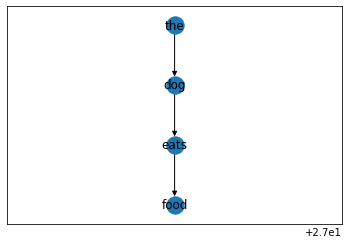

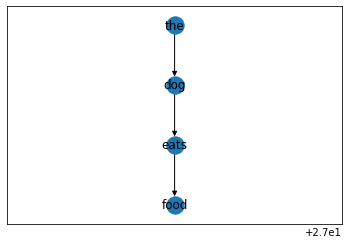

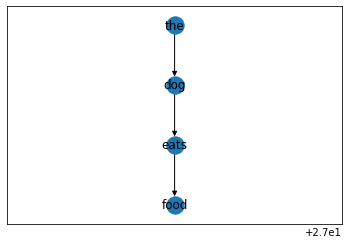

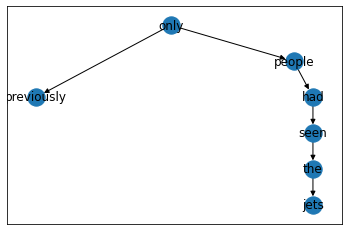

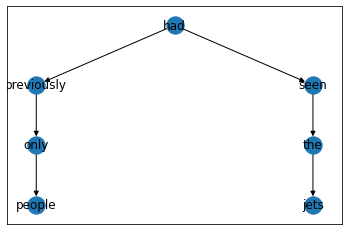

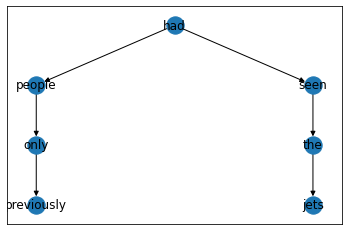

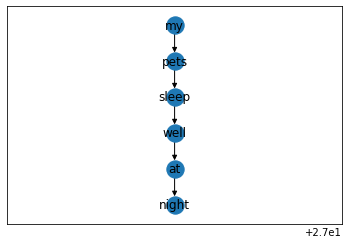

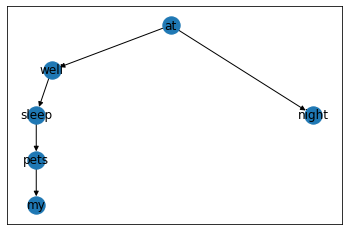

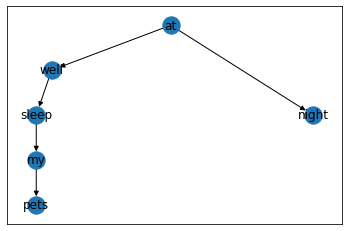

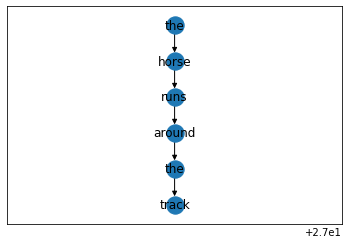

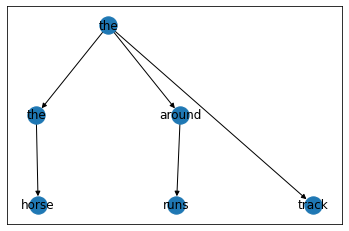

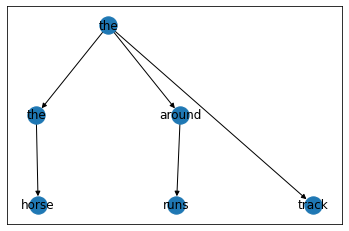

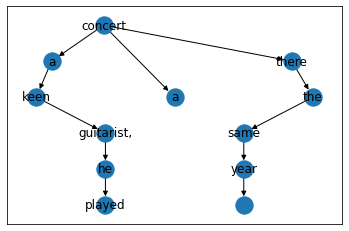

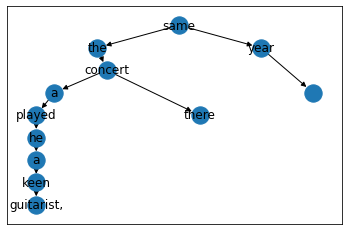

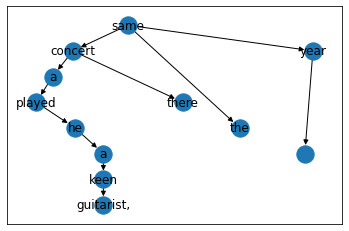

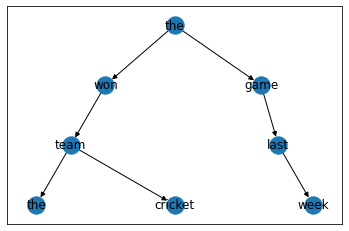

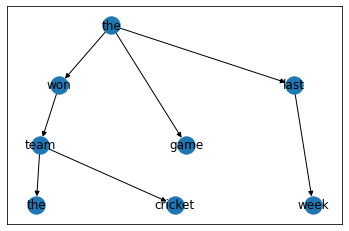

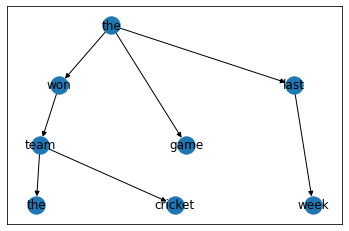

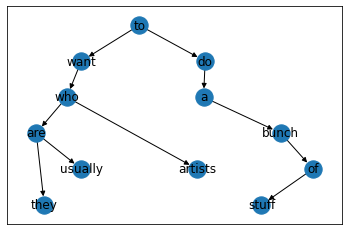

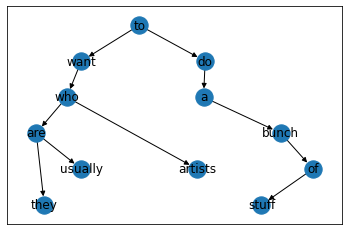

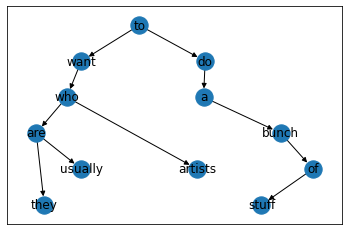

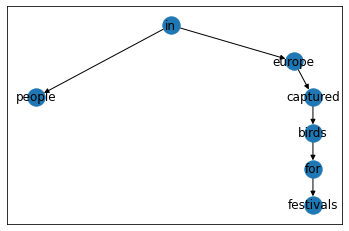

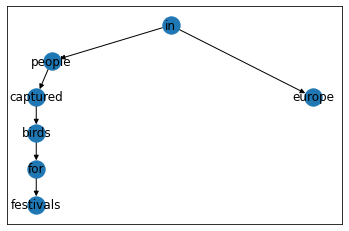

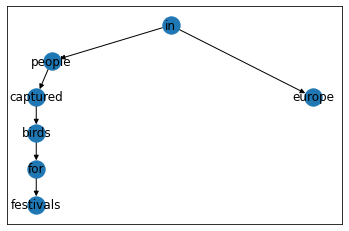

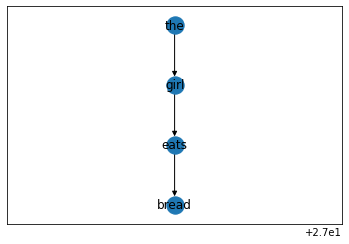

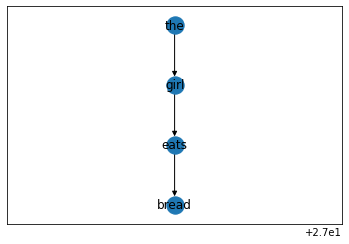

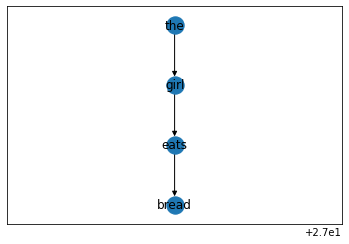

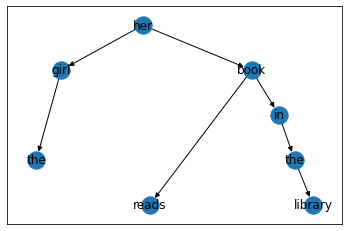

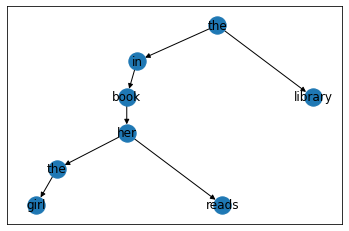

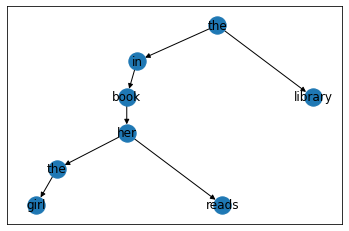

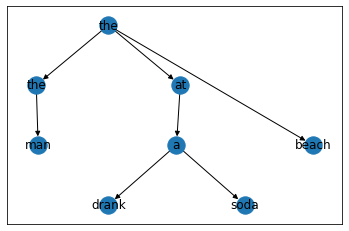

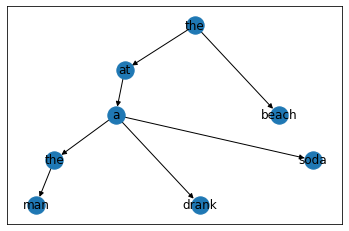

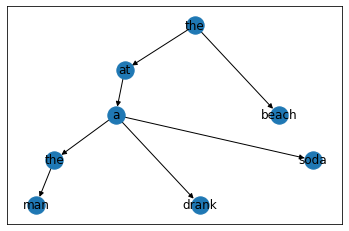

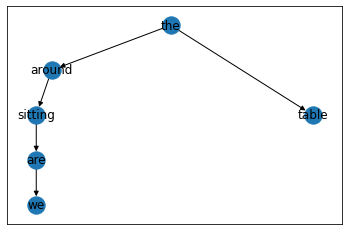

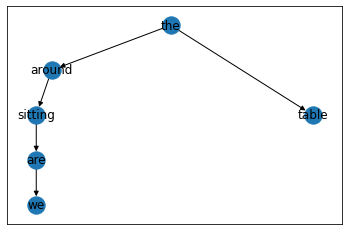

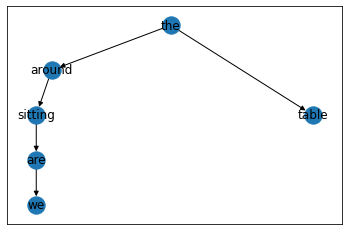

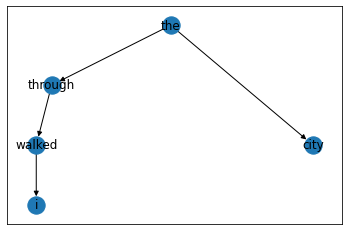

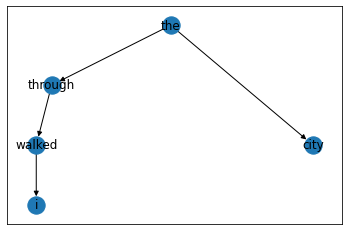

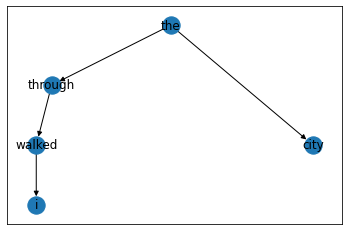

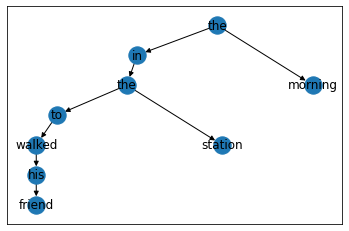

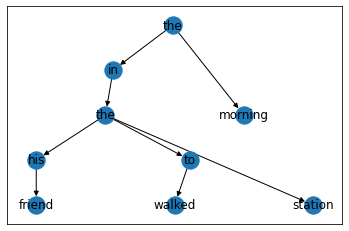

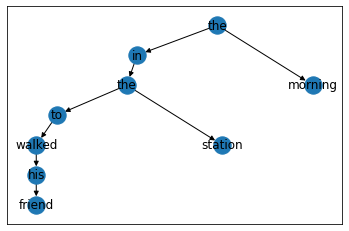

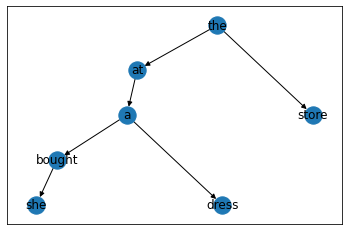

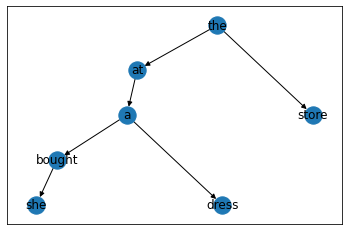

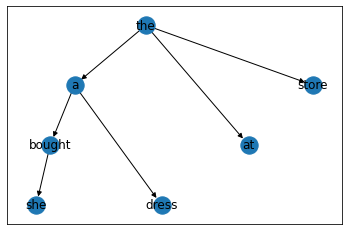

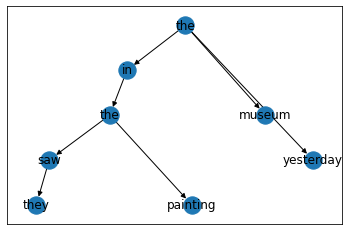

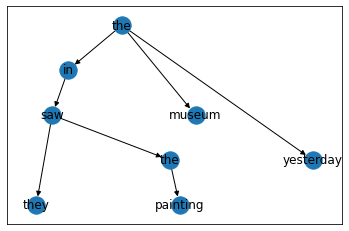

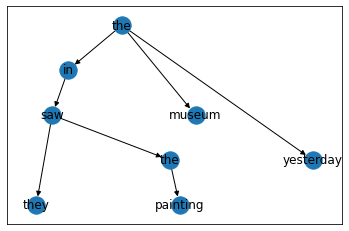

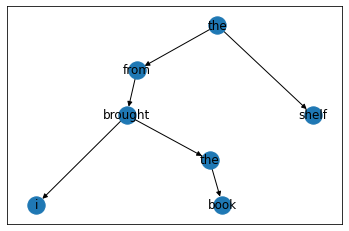

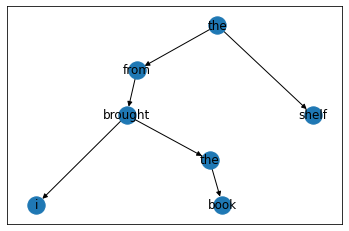

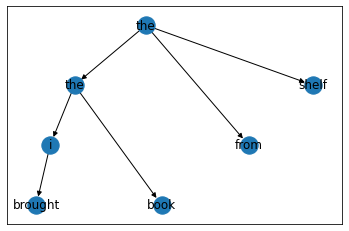

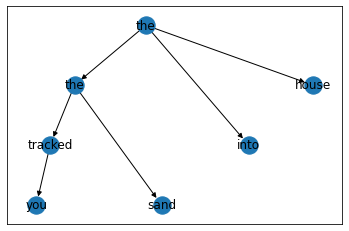

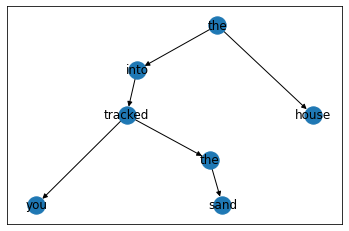

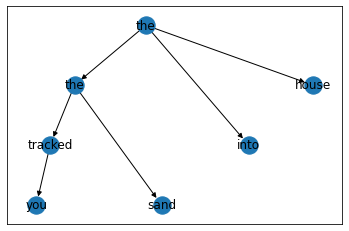

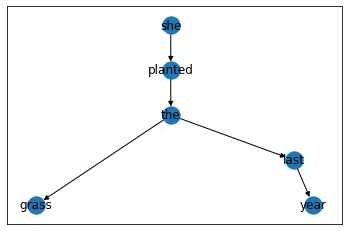

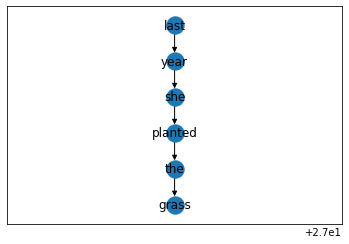

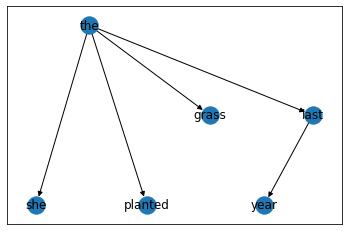

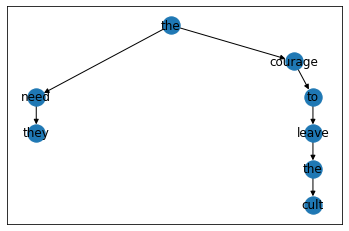

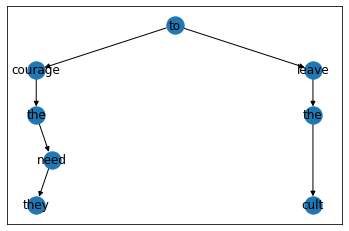

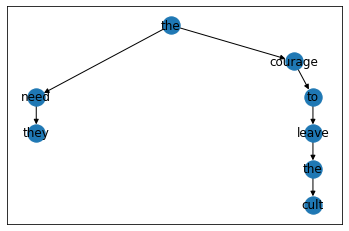

In [ ]:
originals = [d['original'] for d in perturb_sents]
for s in originals:
  l = s.split()
  label = {i : x for i, x in enumerate(l)}
  G_tree = get_max_trees_specific(s, perturb_sim_heads_avg_graph)
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()
  G_tree = get_max_trees_specific(s, all_layers_graph)
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()
  G_tree = get_max_trees_specific(s, baseline_all_layers_graph)
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()


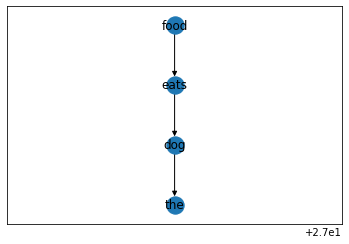

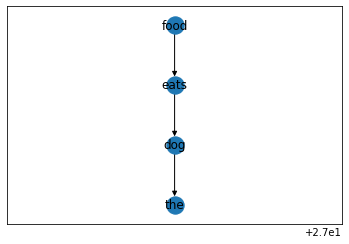

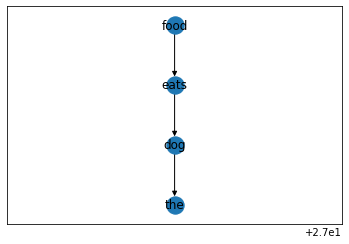

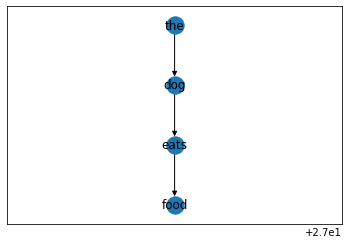

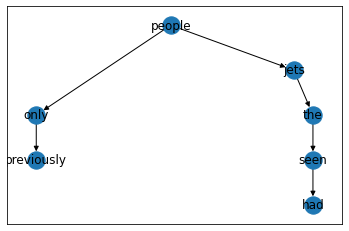

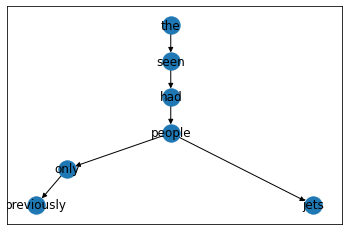

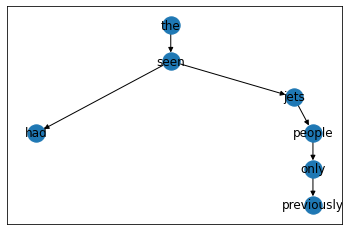

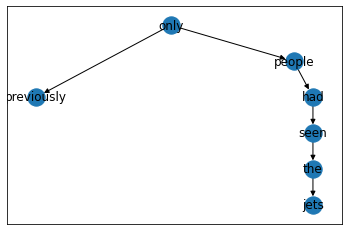

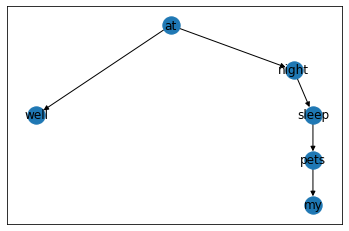

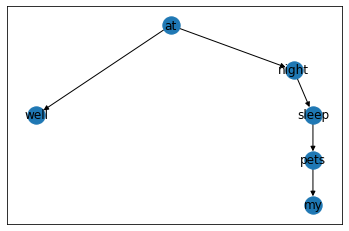

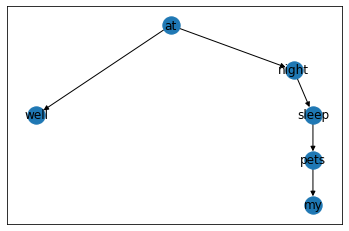

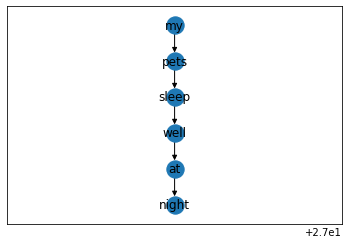

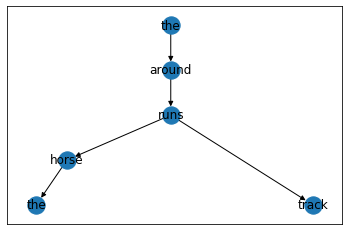

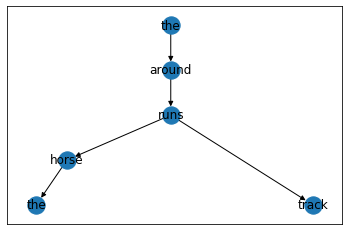

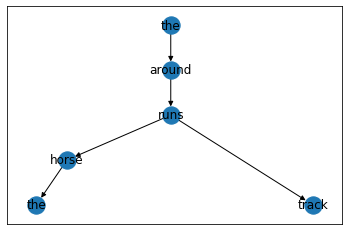

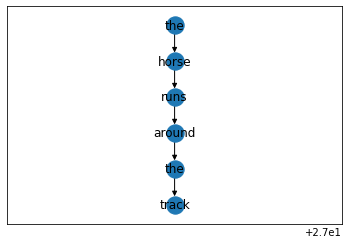

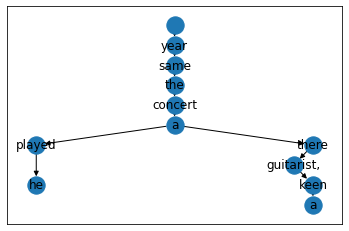

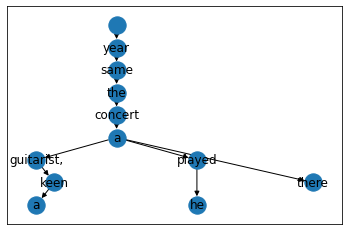

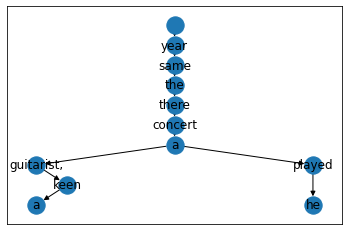

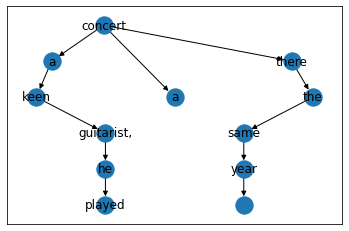

In [ ]:
originals = [d['original'] for d in perturb_sents]
for s in originals[:5]:
  G_tree = get_max_trees(s, perturb_atts_graphs, 0)
  #l = ('[CLS] ' + s + ' [SEP]').split()
  l = s.split()
  label = {i : x for i, x in enumerate(l)}
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()
  G_tree = get_max_trees(s, perturb_across_avg_graphs, 0)
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()
  G_tree = get_max_trees(s, perturb_across_mult_graphs, 0)
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()
  l = s.split()
  label = {i : x for i, x in enumerate(l)}
  G_tree = get_max_trees_specific(s, perturb_sim_heads_avg_graph)
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()

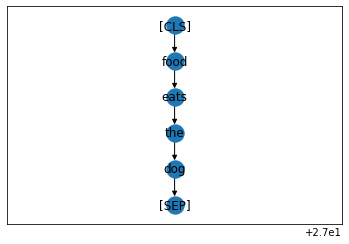

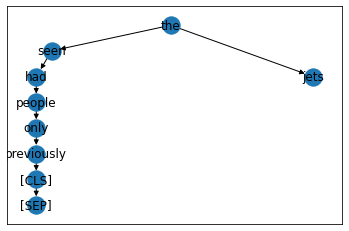

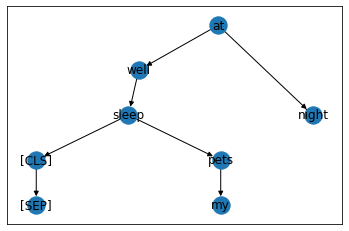

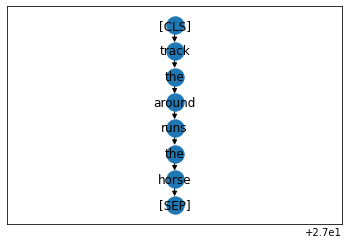

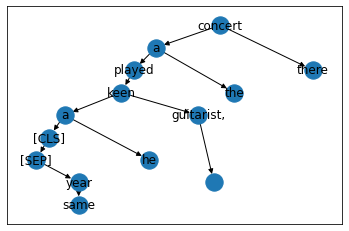

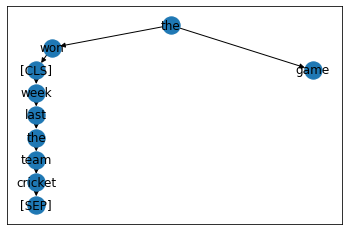

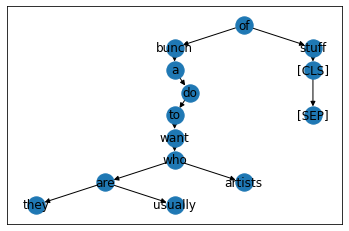

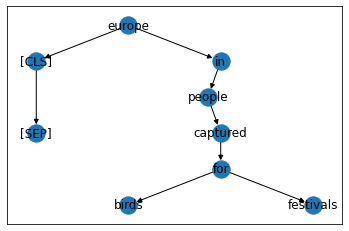

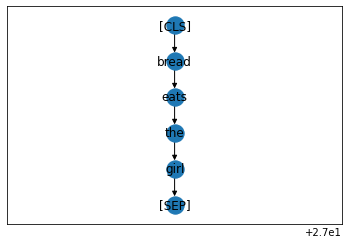

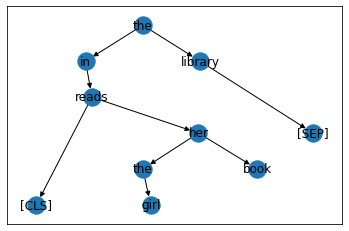

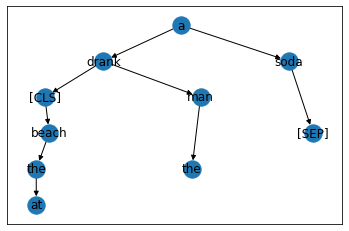

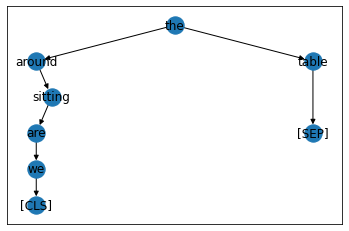

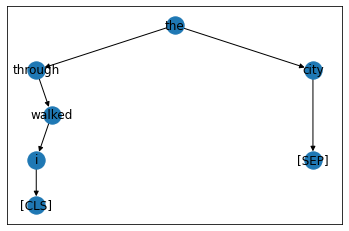

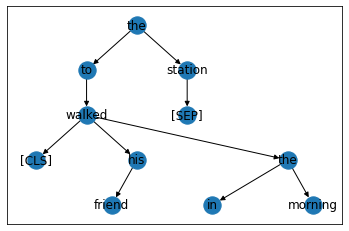

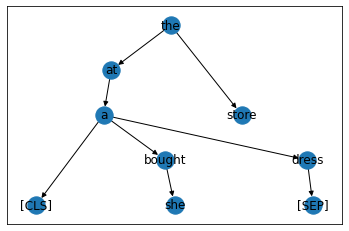

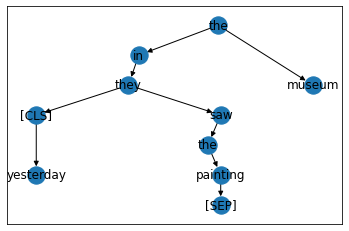

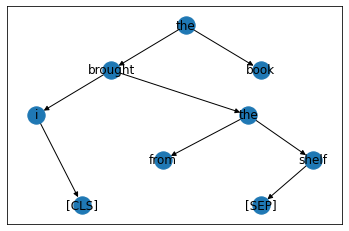

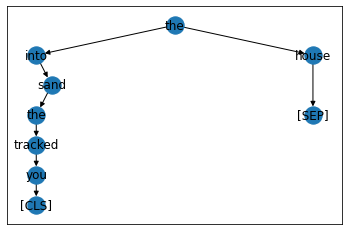

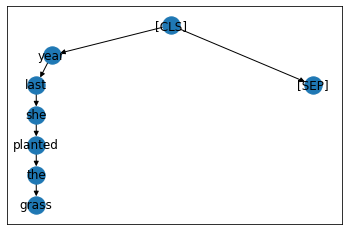

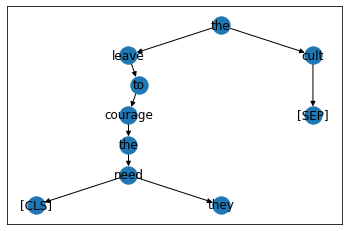

In [ ]:
for s in originals:
  G_tree = get_max_trees(s, perturb_across_avg_graphs, 7)
  l = ('[CLS] ' + s + ' [SEP]').split()
  label = {i : x for i, x in enumerate(l)}
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()

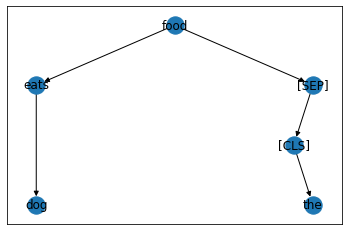

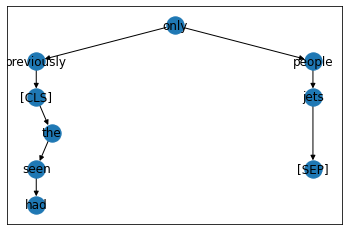

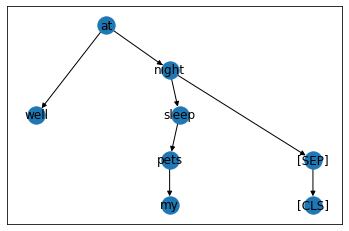

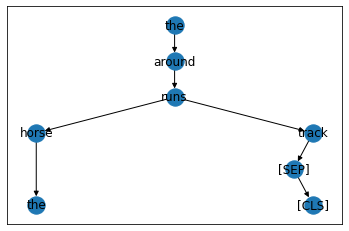

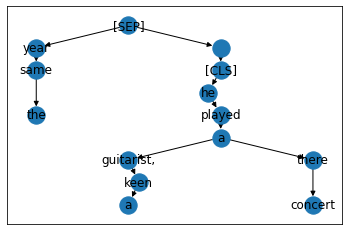

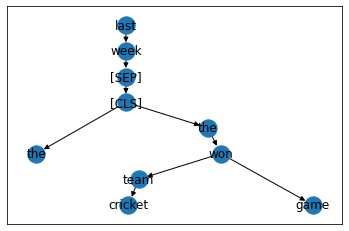

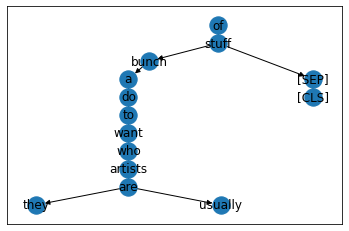

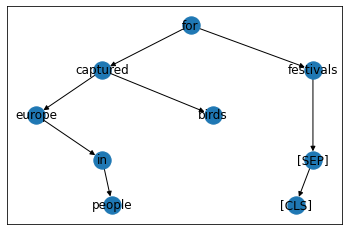

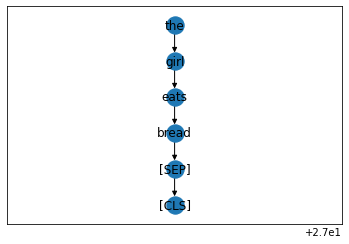

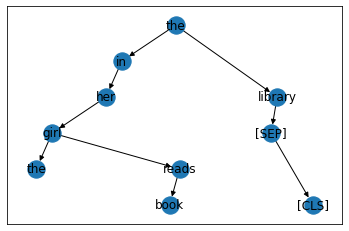

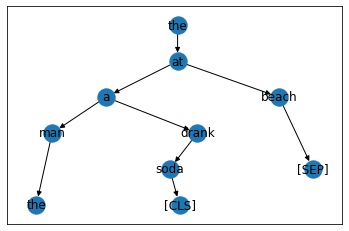

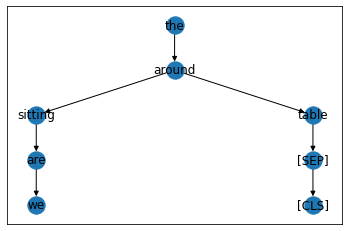

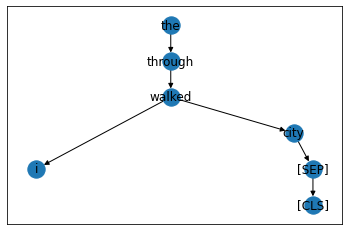

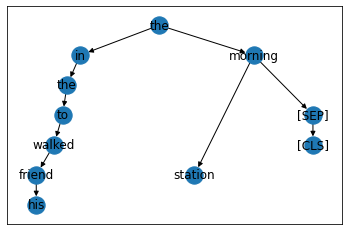

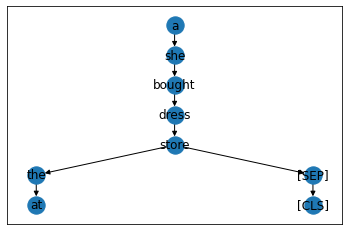

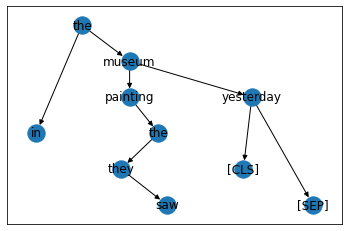

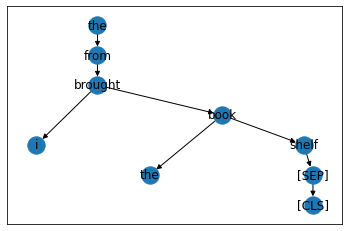

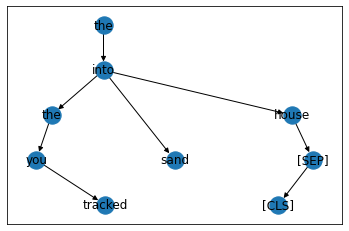

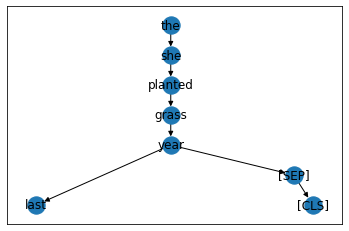

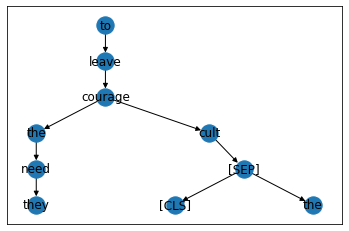

In [ ]:
for s in originals:
  G_tree = get_max_trees(s, perturb_across_mult_graphs, 0)
  l = ('[CLS] ' + s + ' [SEP]').split()
  label = {i : x for i, x in enumerate(l)}
  pos = graphviz_layout(G_tree, prog="dot")
  nx.draw_networkx(G_tree, pos=pos, labels=label)
  plt.show()

Layer: 1


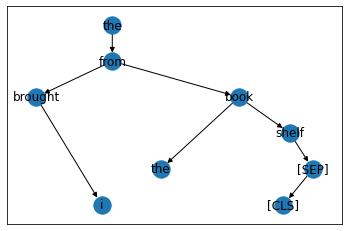

Layer: 2


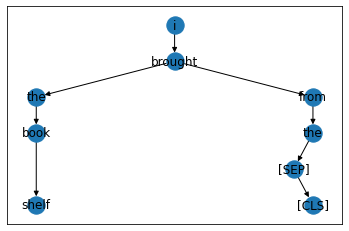

Layer: 3


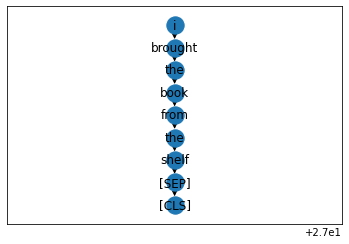

Layer: 4


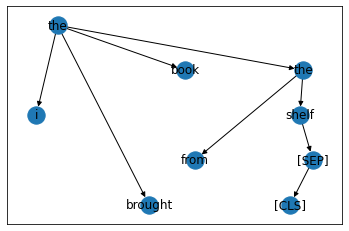

Layer: 5


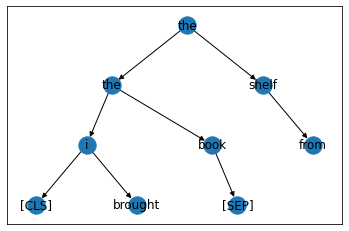

Layer: 6


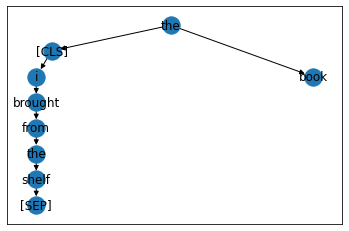

Layer: 7


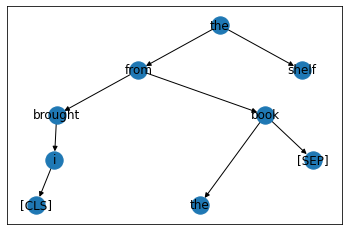

Layer: 8


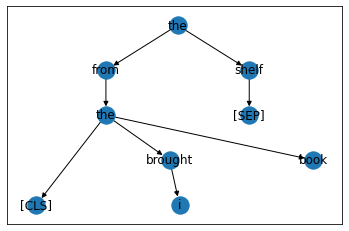

Layer: 9


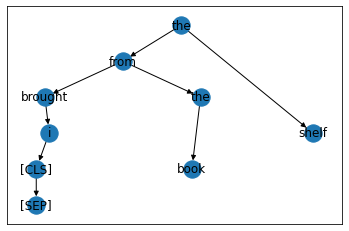

Layer: 10


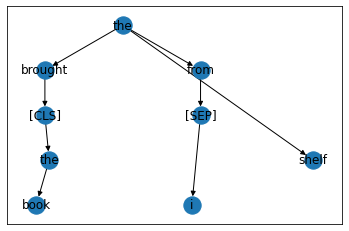

Layer: 11


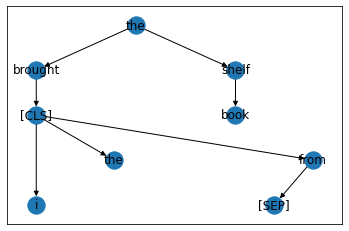

Layer: 12


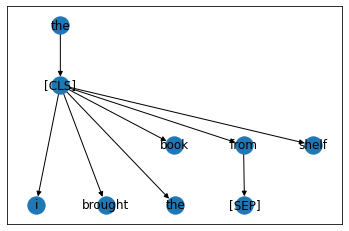

In [ ]:
display_max_trees('i brought the book from the shelf', perturb_atts_graphs)

Layer: 1


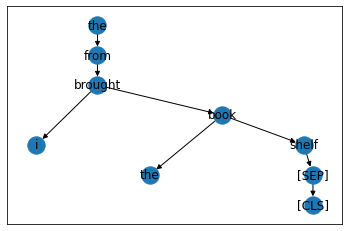

Layer: 2


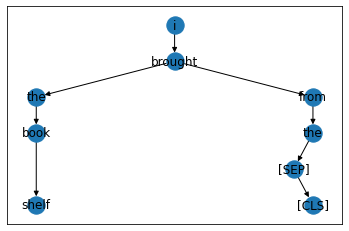

Layer: 3


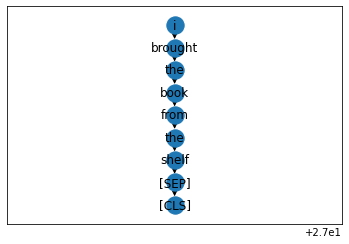

Layer: 4


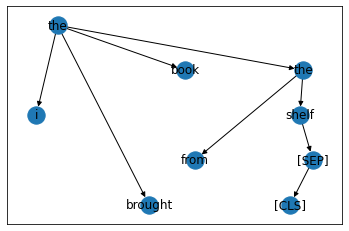

Layer: 5


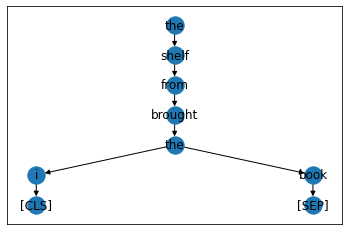

Layer: 6


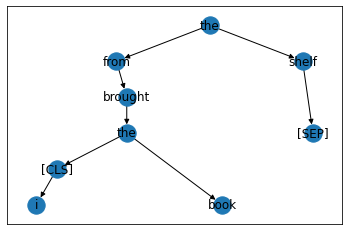

Layer: 7


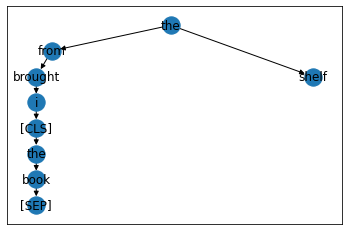

Layer: 8


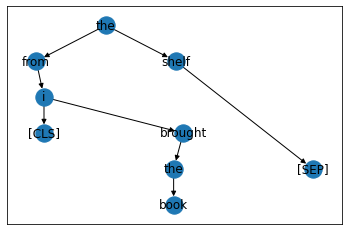

Layer: 9


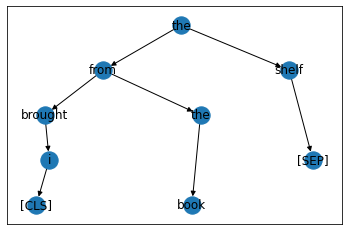

Layer: 10


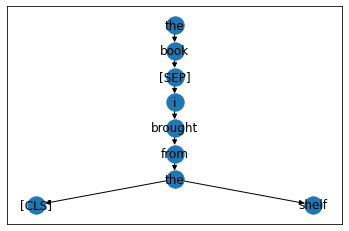

Layer: 11


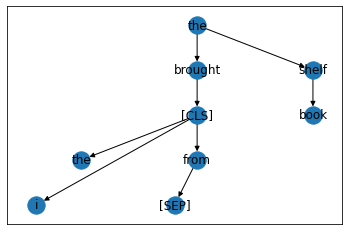

Layer: 12


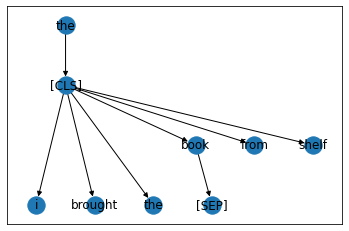

In [ ]:
display_max_trees('i brought the book from the shelf', perturb_across_mult_graphs)

Layer: 1


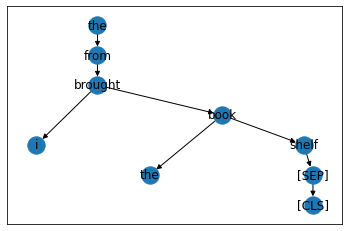

Layer: 2


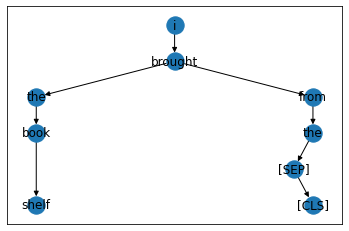

Layer: 3


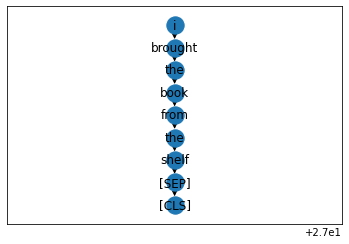

Layer: 4


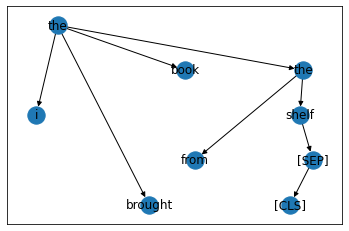

Layer: 5


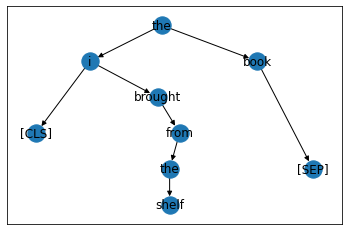

Layer: 6


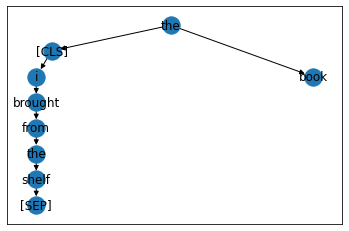

Layer: 7


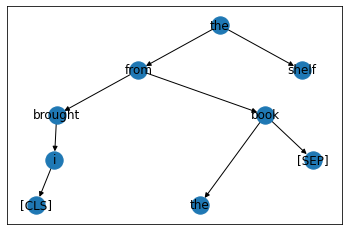

Layer: 8


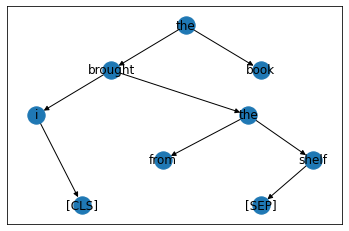

Layer: 9


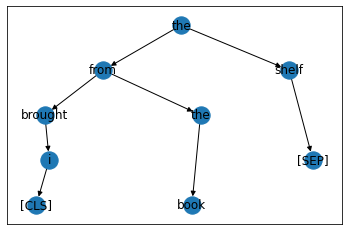

Layer: 10


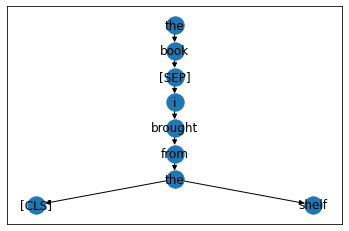

Layer: 11


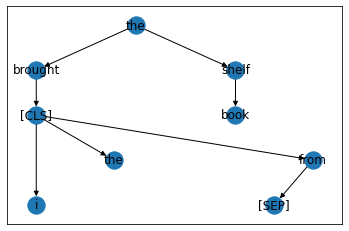

Layer: 12


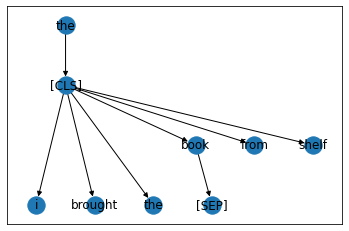

In [ ]:
display_max_trees('i brought the book from the shelf', perturb_across_avg_graphs)

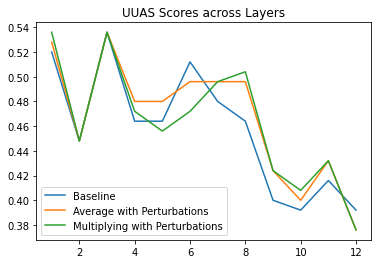

In [ ]:
x = [i for i in range(1, 13)]
y_avg = [uuas_averaging["Layer" + str(i)] for i in range(12)]
y_baseline = [uuas_baseline["Layer" + str(i)] for i in range(12)]
y_multiplying = [uuas_multiplying["Layer" + str(i)] for i in range(12)]
plt.plot(x, y_baseline)
plt.plot(x, y_avg)
plt.plot(x, y_multiplying)
plt.legend(['Baseline', 'Average with Perturbations', 'Multiplying with Perturbations'])
plt.title("UUAS Scores across Layers")
plt.show()

In [ ]:
print("Average Baseline UUAS")
print(sum(y_baseline)/12)
print("Average Averaging UUAS")
print(sum(y_avg)/12)
print("Average Multiplying UUAS")
print(sum(y_multiplying)/12)

Average Baseline UUAS
0.4573333333333334
Average Averaging UUAS
0.46600000000000014
Average Multiplying UUAS
0.46333333333333343
